# Experiments
### Notebook to run experiments on the data supplied by the chair of functional materials at Saarland University

## Experiment 1
### Run RAFT optical flow model on the data
<font size="5"> 
In this experiment we will run the RAFT optical flow model on the data to see how well it performs compared to classical optical flow methods.
</font>

### Results
<font size="5"> 
RAFT tracks the reaction front quite well. The reaction front is visible in the optical flow images but there is also a lot of noise.

</font>

In [15]:
import torch
from raft.utils import get_video_frames, plot_frames, preprocess

In [16]:
video_path = "videos/double_c_shape.mp4"
frames = get_video_frames(video_path)

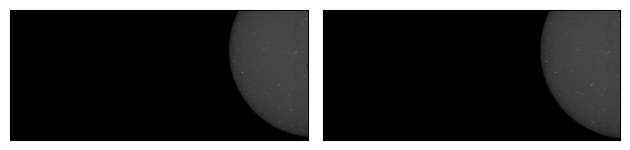

In [3]:
# Change the numbers in frames to see different images.
img_batch = torch.stack([frames[50], frames[51]])
plot_frames(img_batch)

In [4]:
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow.raft import Raft_Large_Weights

model = raft_large(weights=Raft_Large_Weights.C_T_V2)
model = model.eval()

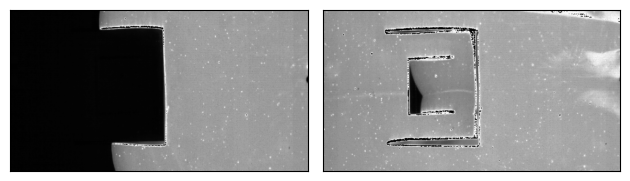

In [17]:
img1_batch: torch.Tensor = preprocess(torch.stack([frames[130], frames[220]]))
img2_batch: torch.Tensor = preprocess(torch.stack([frames[131], frames[221]]))

plot_frames(img1_batch)

In [18]:
img1_batch.shape

torch.Size([2, 3, 520, 960])

In [6]:
predicted_flows: torch.Tensor = model(img1_batch, img2_batch)[-1]

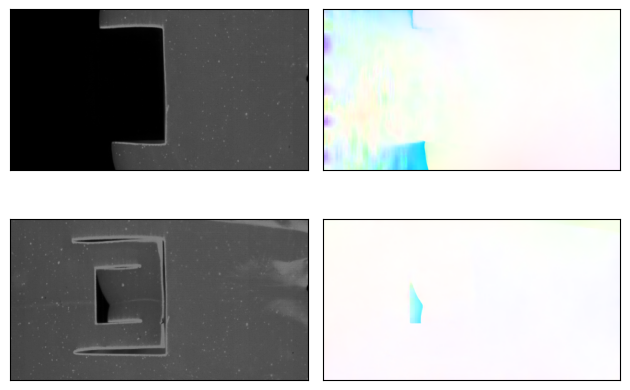

In [7]:
from torchvision.utils import flow_to_image
flow_images = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = (img1_batch + 1.) / 2.

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_images)]
plot_frames(grid) 

## Experiment 2
### Obtain reaction front from difference between frames
<font size="5"> 
In this experiment we will see how well we can obtain the reaction front by simply taking the difference between frames. We set pixels with very small and large differences between two frames to zero, as they seem to be noise. We also binarize the image to make the front more visible. For further denoising we apply a morphological operation called <i>Opening</i>, which removes all white spots smaller than a certain size. Mathematical morphology in the context of image processing deals with analysing and modifying structures in an image based on their geometrical properties. 
</font>

### Results
<font size="5"> 
The reaction front is actually quite visible in the difference between frames. This is a very simple method to obtain the reaction front.  The method also seems to outperform the old optical flow method in terms of noise and also speed.
</font>

In [1]:
from skimage import morphology
from tqdm import tqdm
from utils.video_handling import get_video_frames
import numpy as np
import cv2
import os

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
footprint = morphology.disk(3)

for video_name in os.listdir("videos/"): 
    print(f"Generating flow for {video_name}")
    video_path = "videos/" + video_name
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    frames = get_video_frames(video_path)
    dir_name = "results/experiment2/"
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
    video_writer = cv2.VideoWriter(dir_name + video_name, fourcc, 10.0, (width, height))
    for i, _ in tqdm(enumerate(frames[:-1])):
        # Calculate the difference between two frames.
        flow = frames[i+1] - frames[i]
        flow = flow.astype(np.uint8)
        
        # Threshold and binarize the image.
        flow[flow > 180] = 0
        flow[flow < 20] = 0
        flow[flow > 0] = 255
        
        # Apply morphological opening.
        flow = morphology.opening(flow, footprint)
        flow = cv2.cvtColor(flow, cv2.COLOR_GRAY2BGR)
        video_writer.write(flow)
        
    video_writer.release()

## Experiment 3
### Track the reaction fronts through the frames
<font size="5"> 
In this experiment we will try to track the reaction front and its offsprings throughout the frames. Since the images will be binarized we can use local connectivity of the pixels as a criterion for tracking. 
</font>

### Results
<font size="5"> 
Segmenting the reaction front and it's offspring works quite good on a per frame basis, but it's difficult to track the different fronts throughout the frames.
</font>

In [3]:
from skimage import morphology, measure
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.video_handling import get_video_frames
import numpy as np
import cv2
import os

In [5]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
footprint = morphology.disk(3)

cmap = plt.get_cmap('tab20')
props_old = None

for video_name in os.listdir("videos/"): 
    print(f"Generating flow for {video_name}")
    video_path = "videos/" + video_name
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    frames = get_video_frames(video_path)
    video_writer = cv2.VideoWriter("results/experiment3/" + video_name, fourcc, 10.0, (width, height))
    for i, _ in tqdm(enumerate(frames[:-1])):
        # Calculate the difference between two frames.
        flow = frames[i+1] - frames[i]
        flow = flow.astype(np.uint8)
        
        # Threshold and binarize the image.
        flow[flow > 180] = 0
        flow[flow < 20] = 0
        flow[flow > 0] = 255
        
        # Apply morphological opening.
        flow = morphology.opening(flow, footprint)
        
        # Label the connected components.
        labeled_flow, num_labels = measure.label(flow, return_num=True)
        labeled_flow = cv2.cvtColor(labeled_flow.astype(np.uint8), cv2.COLOR_GRAY2BGR)
        flow = cv2.cvtColor(flow, cv2.COLOR_GRAY2BGR)
        
        for j in range(1, num_labels):
            color = cmap(j)
            color_array = (np.array(color[:-1]) * 255).astype(np.uint8)
            flow = np.where(labeled_flow == j, color_array, flow)
            
        video_writer.write(flow)
    
    video_writer.release()

NameError: name 'plt' is not defined

## Experiment 4
### Apply optical flow to the binarized video frames
<font size="5"> 
In this experiment we will apply an optical flow algorithm to the binarized videos to get a vector field describing the speed of the reaction front at each point in time.

04.05.2024:
- Try adding skeletonization before calculating the optical flow and use opencv's calcOpticalFlowFarneback function.

05.05.2024:
- I tried playing around with the parameters of the algorithm like *poly_sigma* and *poly_n*.
</font>
<br><br>

### Hypothesis
<font size="5">
Since the frames are almost noise free I expect the optical flow algorithm to perform quite well on the data.
</font>
<br><br>

### Results
<font size="5"> 
The algorithm fails spectacularily, seemingly tracking the reaction fronts but also causing seemingly random splashes of greytones.

04.05.2024:
- After applying skeletonization there are no splashes anymore, but there still is noise and the flow seems to be too thick.

05.05.2024:
- Modifying the parameters doesn't improve the result.
</font>

In [2]:
from skimage import morphology
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.video_handling import get_video_frames
import numpy as np
import cv2
import os

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
footprint = morphology.disk(3)

cmap = plt.get_cmap('plasma')
props_old = None

for video_name in os.listdir("videos/"): 
    print(f"Generating flow for {video_name}")
    video_path = "videos/" + video_name
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    frames = get_video_frames(video_path)
    
    dir_name = "results/experiment4_farneback_poly_sigma_0_2_poly_n_3/"
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
        
    video_writer = cv2.VideoWriter(dir_name + video_name, fourcc, 10.0, (width, height))
    
    for i, _ in tqdm(enumerate(frames[1:-1])):
        # Calculate the difference between two frames.
        diff_flow0 = (frames[i+1] - frames[i]).astype(np.uint8)
        diff_flow1 = (frames[i] - frames[i-1]).astype(np.uint8)
        
        # Threshold and binarize the image.
        diff_flow0[diff_flow0 > 180] = 0
        diff_flow0[diff_flow0 < 20] = 0
        diff_flow0[diff_flow0 > 0] = 255
        
        diff_flow1[diff_flow1 > 180] = 0
        diff_flow1[diff_flow1 < 20] = 0
        diff_flow1[diff_flow1 > 0] = 255
        
        # Apply morphological opening.
        diff_flow0 = morphology.opening(diff_flow0, footprint)
        diff_flow1 = morphology.opening(diff_flow1, footprint)
        
        diff_flow0 = morphology.skeletonize(diff_flow0)
        diff_flow1 = morphology.skeletonize(diff_flow1)
        
        diff_flow0 = np.where(diff_flow0 == 1, 255, 0).astype(np.uint8)
        diff_flow1 = np.where(diff_flow1 == 1, 255, 0).astype(np.uint8)
        
        flow_field = cv2.calcOpticalFlowFarneback(diff_flow0, diff_flow1, None, 0.5, 3, 15, 3, 3, 0.2, 0)
        
        flow = np.sqrt(flow_field[:, :, 0]**2 + flow_field[:, :, 1]**2).astype(np.uint8)
        flow = cv2.cvtColor(flow, cv2.COLOR_GRAY2BGR) 
                
        video_writer.write(flow)
        
    video_writer.release()


## Experiment 5
### Apply skeletonization to the binarized video frames
<font size="5"> 
In this experiment we will apply skeletonization to the binarized videos to get a more sharp representation of the reaction front.
</font>

### Hypothesis
<font size="5">
Will look like the previous experiments but with thin lines instead of blobs.
</font>

### Results
<font size="5"> 
Hypothesis turned out to be correct, there is still some noise present which I might be able to remove with more morphological operations.
</font>

In [1]:
from skimage import morphology
from tqdm import tqdm
from utils.video_handling import setup_experiment
from utils.frame_processing import front_from_frames
import cv2
import os

In [ ]:
footprint = morphology.disk(3)
for video_name in os.listdir("videos/"): 
    video_writer, frames = setup_experiment(video_name, "results/experiment5_low_threshold_15/")
    for i, _ in tqdm(enumerate(frames[:-1])):
        front = front_from_frames(frames[i], frames[i+1], footprint)  
        front = cv2.cvtColor(front, cv2.COLOR_GRAY2BGR)
        video_writer.write(front)
        
    video_writer.release()

## Experiment 6
### Plot evolution of reaction front on a single canvas
<font size="5"> 
In this experiment we will plot the reaction front at each time stept on a single canvas to get an overview over its evolution in time from a single image.
</font>

### Results
<font size="5"> 
Fronts are clearly visible in most images. Only the videos with low resolutions and the one with the dots yield unclear images
</font>


In [28]:
from utils.video_handling import get_video_frames
import matplotlib.pyplot as plt
from skimage import morphology

In [ ]:
footprint = morphology.disk(3)
for video_name in os.listdir("videos/"): 
    frames = get_video_frames("videos/" + video_name)
    # Initialize the front
    h, w = frames[0].shape
    front =  np.zeros((h, w), dtype=np.uint8)
    for i, _ in tqdm(enumerate(frames[:-1])):
        front += front_from_frames(frames[i], frames[i+1], footprint)  
    fig = plt.figure(dpi=200)
    plt.imshow(front)
    plt.axis('off')
    plt.title("Reaction Front Progression - {}".format(video_name))
    result_dir = "results/experiment6/"
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)
    plt.savefig(result_dir + video_name + ".png")       
    plt.close(fig)

## Experiment 7
### Calculate distance travelled by reaction front
<font size="5"> 
In this experiment we will calculate the distance travelled by the reaction fronts between two frames by fitting contour lines to at each timestep and calculating their distance.
</font>

### Results
<font size="5"> 
Fronts are clearly visible in most images. Only the videos with low resolutions and the one with the dots yield unclear images
</font>

In [1]:
from utils.video_handling import get_video_frames
from utils.frame_processing import front_from_frames
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy import interpolate

In [ ]:
frames = get_video_frames("videos/double_c_shape.mp4")
footprint = morphology.disk(3)
# Initialize the front
h, w = frames[0].shape
front =  np.zeros((h, w), dtype=np.uint8)
fronts = []
for i, _ in tqdm(enumerate(frames[:-1])):
    front = front_from_frames(frames[i], frames[i+1], footprint)
    fronts.append(front)

Text(0.5, 1.0, 'Contour Lines of Reaction Front')

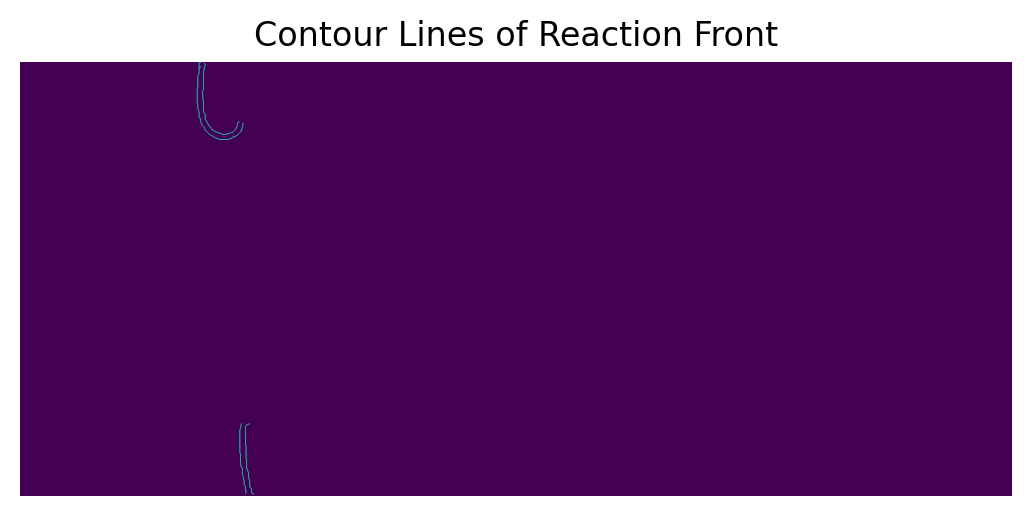

In [11]:
fig = plt.figure(dpi=200)
image = fronts[150] + fronts[151]
plt.imshow(image)
plt.axis("off")
plt.title("Contour Lines of Reaction Front")

<font size="5">Calculate the average distance between the two fronts by determining for each pixel on front 1 the closest pixel on front 2 and then taking the average of these distances.</font>

In [3]:
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
distances = cdist(np.squeeze(contours[0]), np.squeeze(contours[1]))
print(f"Average Distance: {np.mean(np.min(distances, axis=0))}")

Average Distance: 8.58560715655026


<font size="5">Now we use scipy to fit splines to the contour lines and plot them.</font>

In [98]:
X0 = np.squeeze(contours[0])[::20, 0]
Y0 = np.squeeze(contours[0])[::20, 1]

X1 = np.squeeze(contours[1])[::20, 0]
Y1 = np.squeeze(contours[1])[::20, 1]

tck0, u0 = interpolate.splprep([X0, Y0], s=1)
tck1, u1 = interpolate.splprep([X1, Y1], s=1)

out0 = np.array(interpolate.splev(u0, tck0)).T
out1 = np.array(interpolate.splev(u1, tck1)).T

tangent0 = interpolate.splev(u0, tck0, der=1)
tangent1 = interpolate.splev(u1, tck1, der=1)

normal0 = np.array([-tangent0[1], tangent0[0]]).T
normal1 = np.array([-tangent1[1], tangent1[0]]).T

normal0 = normal0 / np.linalg.norm(normal0, axis=1).reshape(-1, 1)
normal1 = normal1 / np.linalg.norm(normal1, axis=1).reshape(-1, 1)

Text(0.5, 1.0, 'Splines fit to Contour Lines')

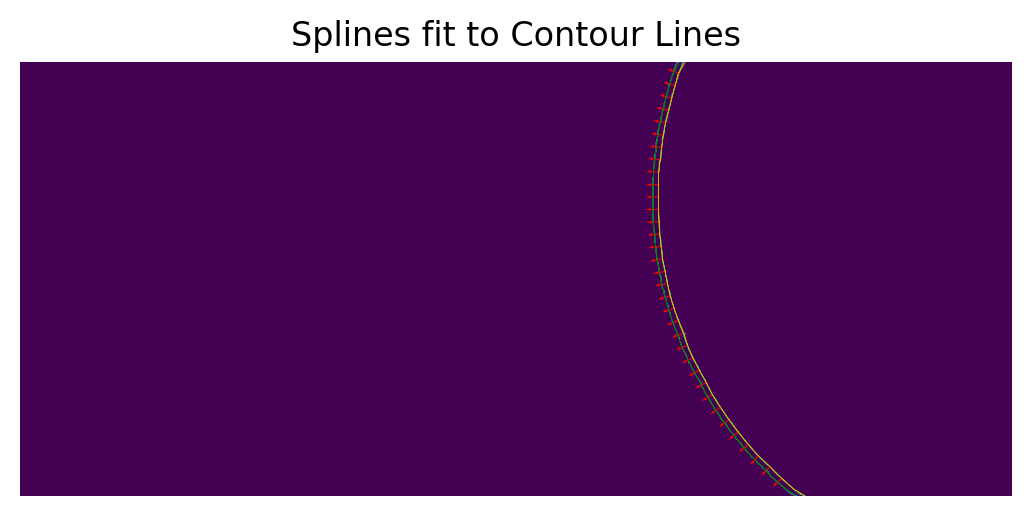

In [101]:
plt.figure(dpi=200)
plt.imshow(image)
plt.plot(out0[:, 0], out0[:, 1], 'y', linewidth=0.25)
plt.plot(out1[:, 0], out1[:, 1], 'g', linewidth=0.25)
plt.quiver(out0[:35, 0], out0[:35, 1], normal0[:35, 0], normal0[:35, 1],
           color='r', angles='xy', scale_units='xy', scale=0.05, width=0.001)
plt.axis("off")
plt.title("Splines fit to Contour Lines")

<font size="5">Calculate the average distance between the two fronts by determining for each pixel on front 1 the closest pixel on front 2 and then taking the average of these distances. Since the splines are sparser than the original reaction front it is to be expected that the average distance is slightly larger.</font>

In [54]:
spline0 = np.array(out0).T
spline1 = np.array(out1).T
distances = cdist(spline0, spline1)
print(f"Average Distance: {np.mean(np.min(distances, axis=0))}")

Average Distance: 9.423382269611215


## Experiment 8
### Fit splines at each timestep.
<font size="5"> 
In this experiment we will try to fit splines to the reaction front at every timestep and evaluate how well the splines fit the front, especially when it comes to fitting small offsprings of the
front and noise.
</font>

### Hypothesis
<font size="5"> 
The splines will fit the front quite well, but will have problems with small offsprings and noise.
</font> 

### Results
<font size="5"> 
</font>